# 당신의 지갑은 언제 열리나요?  코로나 속 한국인의 소비동향


## 목차

- 포스트 코로나 시대의 유망산업 탐색
- 데이터 전처리

### 1. 배달(delivery.csv)과 유동인구(fpopl.csv), 코로나와의 관계

      1. 배달건수와 배달시간
      2. 배달시간과 코로나 확진자수의 관계
      3. 배달 건수와 배달 시간, 그리고 코로나 확진자수의 관계
      4. 유동인구와 배달건수의 관계
      5. 유동인구와 확진자수의 관계
      
### 2. 달별로 Card.csv 분류 (여행, 식품, 의료용품)

### 3. 업종별 카드매출발생건수 비교 (여행 식품, 의료용품)

    - 업종별 카드 사용내역 데이터(의료용품)
    - 업종별 카드 사용내역 데이터(식품)
    - 업종별 카드 사용내역 데이터(여행)
    - 매 월별로 식품과 의료용품 매출발생건수 비교
    - 매 월별로 여행과 의료용품 매출발생건수 비교
    - 매 월별로 식품과 여행 매출발생건수 비교
    - 매 월별로 식품과 여행, 의료용품 매출발생건수 비교 

### 4. 코로나 확진자수와 카드사용률의 관계

### 5. 주차별 코로나 확진자 수와 카드 데이터 사용 내역의 연관성 비교

### 6. 지도(유동인구, 성장지수, 카드매출발생현황)

### 7. 결론


# Intro.
- 저희는 포스트 코로나 시대의 유망산업을 찾기 위해 먼저 코로나 이전과 이후를 비교할 수 있는 Index.csv 파일의 Cgi(2018년 대비 성장지수)를 살펴보았습니다.


### 데이터 분석을 위한 라이브러리들 불러오기

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)

In [5]:
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot

import matplotlib.animation as animation

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [6]:
from IPython.display import Image

In [7]:
%matplotlib inline

plt.rcParams['axes.unicode_minus'] = False

In [8]:
from pandas import DataFrame as df

In [9]:
pd.options.plotting.backend = 'plotly'

import plotly.io as pio
pio.renderers.default = "notebook_connected"

- CGI는 2018년 대비 산업의 성장 수치이므로, 코로나 이후인 2020년 01월부터 05월까지 추출했습니다. 대분류 4개 품목에 대한 CGI가 100이상인, 즉 2018년에 비해 성장한 산업의 개수의 비율을 계산해보았습니다.
  그 결과, 아래와 같은 그래프가 도출되었습니다.


In [10]:
index_data=pd.read_csv("index.csv")


In [11]:
index=index_data[(index_data["period"] >=202001) & (index_data["period"] <=202005)]
index[index["cgi"]>100]["catl"].value_counts()/index["catl"].value_counts()

건강/의료용품    0.368285
식품         0.313996
일용품        0.171658
화장품        0.159830
Name: catl, dtype: float64

In [12]:
df=df(data={'catl':['건강/의료용품',"식품","일용품","화장품"],
            'per': ["0.368285","0.313996",'0.171658','0.159830']})

In [13]:
df['per'] = df['per'].astype(float)

<AxesSubplot:xlabel='catl', ylabel='per'>

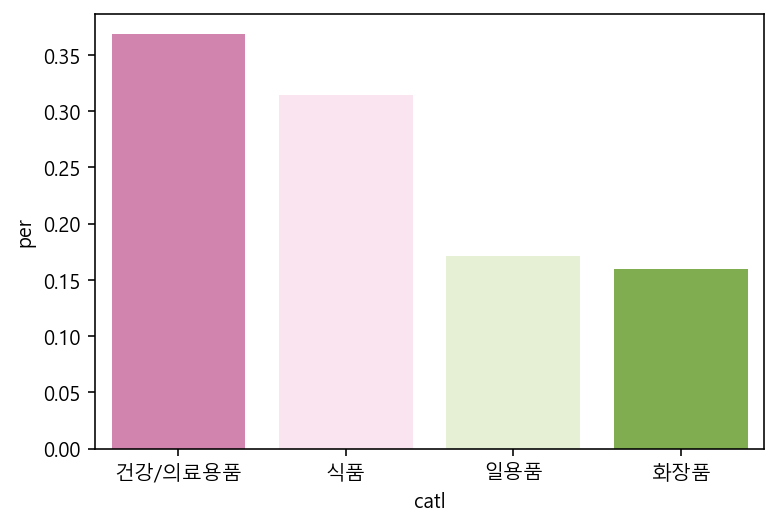

In [14]:
sns.barplot(data=df,x="catl",y='per',palette='PiYG')

 
- 건강/의료용품과 식품의 성장 비율이 가장 높았기에 이 두 가지 품목을 토대로 서울지역을 분석해보았습니다.


### 필요한 데이터들 불러오기

In [15]:
delivery=pd.read_csv("delivery.csv")

In [16]:
adstrd_master_data=pd.read_csv("adstrd_master.csv")

In [17]:
time=pd.read_csv("COVID_19/Time.csv")

In [18]:
fpopl=pd.read_csv("fpopl.csv")

### delivery.csv 전처리

In [19]:
#delivery의 columns를 필요한 항목만 가져오기
cols=["PROCESS_DT","DLVR_REQUST_STTUS_VALUE","DLVR_STORE_ADSTRD_CODE","DLVR_STORE_INDUTY_NM","DLVR_CARALC_TIME","DLVR_COMPT_TIME"]
delivery=delivery[cols]
#delivery["DLVR_REQUST_STTUS_VALUE"]가 1 값인 데이터들만 가져오기
delivery=delivery[delivery["DLVR_REQUST_STTUS_VALUE"]==1]
delivery.columns=["처리날짜(datetime)","배달요청상태값","행정동코드","업종분류","배차시간","완료시간"]
delivery=delivery.drop("배달요청상태값",axis=1)
#delivery 데이터는 행정동코드가 100곱해져 있는 상태이므로 100으로 나눈다.
delivery["행정동코드"]=delivery["행정동코드"]/100
delivery["행정동코드"]=delivery["행정동코드"].astype(int)
#서울에 해당하는 데이터만 가져오기
delivery=delivery[(delivery["행정동코드"] >=11110515) & (delivery["행정동코드"] <=11740700)]
delivery=delivery.drop("행정동코드",axis=1)
#delivery를 주차별로 배달건수를 카운트한 데이터를 만든다
delivery_week=delivery.drop(["배차시간","완료시간","업종분류"],axis=1)
delivery_week["건수"]=1
delivery_week["건수"]=delivery_week["건수"].astype(int)
delivery_week["처리날짜(datetime)"] = pd.to_datetime(delivery_week["처리날짜(datetime)"], format="%Y-%m-%d")
delivery_week.set_index(delivery_week['처리날짜(datetime)'], inplace=True)
delivery_week=delivery_week.drop("처리날짜(datetime)",axis=1)
delivery_week = delivery_week.resample('W-sun').agg(sum)
delivery_week=delivery_week.reset_index(drop=False,inplace=False)
#월-주차로 배달 건수 카운트하기
delivery_week["처리날짜(datetime)"]=delivery_week["처리날짜(datetime)"].astype(str)
delivery_week["월"] = delivery_week["처리날짜(datetime)"].str.slice(start=5, stop=7)
delivery_week["주"] = [i for j in (range(1,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,4)) for i in j]
delivery_week["월-주차"] = delivery_week["월"].astype(str) + str('월 ') + delivery_week["주"].astype(str) + str('주차')
delivery_week = delivery_week.drop(['월','주'],axis=1)
cols = ['월-주차', '처리날짜(datetime)', '건수']
delivery_week = delivery_week[cols]


배달 데이터에서 배차시간과 완료시간의 차이 시간을 통해 배달시간을 구하고 배달 음식중 top3를 정해서 평균 배달시간을 알아본다.

In [20]:
delivery["배차시간뉴"] = pd.to_datetime(delivery["배차시간"], format="%Y-%m-%d %H:%M:%S")
delivery["완료시간뉴"] = pd.to_datetime(delivery["완료시간"], format="%Y-%m-%d %H:%M:%S")
delivery["결과"] = delivery["완료시간뉴"]-delivery["배차시간뉴"]
#완료시간이 배차시간보다 빠른 경우도 있음 드랍함
delivery=delivery.drop(["배차시간뉴","완료시간뉴"],axis=1)
delivery["결과"]=delivery["결과"].astype(str)
#음식 배달의 경우 하루를 넘어가지 않기 때문에 24시간 안에 있는 데이터들만 가져온다
delivery=delivery[delivery["결과"].str.contains("0 days")]
delivery["결과"]=delivery["결과"].str.replace("0 days","")
delivery["결과"]=delivery["결과"].str[4:6]
delivery["결과"]=delivery["결과"].astype(int)
delivery["업종분류"].value_counts().head(3)
#치킨,분식,패스트푸드가 top3로 나왔다.
delivery["처리날짜(datetime)"] = pd.to_datetime(delivery["처리날짜(datetime)"], format="%Y-%m-%d")
delivery_ch=delivery[delivery["업종분류"]=="치킨"]
delivery_bs=delivery[delivery["업종분류"]=="분식"]
delivery_ff=delivery[delivery["업종분류"]=="패스트푸드"]
# [처리날짜(datetime)]에 따라 groupby를 통해 일별로 된 결과를 얻습니다.
delivery_ff_time = delivery_ff.groupby(delivery_ff['처리날짜(datetime)']).mean()['결과']
delivery_bs_time = delivery_bs.groupby(delivery_bs['처리날짜(datetime)']).mean()['결과']
delivery_ch_time = delivery_ch.groupby(delivery_ch['처리날짜(datetime)']).mean()['결과']
# resample('W-Sun')을 통해 주별로, 일요일을 기준으로 다시 데이터를 묶어 각각 저장합니다.
ff_week = delivery_ff_time.resample('W-Sun').mean()
bs_week = delivery_bs_time.resample('W-Sun').mean()
ch_week = delivery_ch_time.resample('W-Sun').mean()
# 위의 데이터셋에는 index가 아직 [처리날짜(datetime)] 이므로 새롭게 인덱스를 정수형태로 추가해줍니다.
ff_week = ff_week.reset_index(drop=False, inplace=False)
bs_week = bs_week.reset_index(drop=False, inplace=False)
ch_week = ch_week.reset_index(drop=False, inplace=False)
#날짜를 그래프로 표기할 경우 월-주차로 하기 위해 변경
ff_week["처리날짜(datetime)"]=ff_week["처리날짜(datetime)"].astype(str)
bs_week["처리날짜(datetime)"]=bs_week["처리날짜(datetime)"].astype(str)
ch_week["처리날짜(datetime)"]=ch_week["처리날짜(datetime)"].astype(str)
#함수사용
def parse_col(df):
    df["월"] = df["처리날짜(datetime)"].str.slice(start=5, stop=7)
    df["주"] = [i for j in (range(1,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,4)) for i in j]
    df["월-주차"] = df["월"].astype(str) + str('월 ') + df["주"].astype(str) + str('주차')
    df.drop(["월","주"],axis=1,inplace=True)
parse_col(ff_week)
parse_col(bs_week)
parse_col(ch_week)
cols = ['월-주차', '처리날짜(datetime)', '결과']
bs_week = bs_week[cols]
cols = ['월-주차', '처리날짜(datetime)', '결과']
ff_week = ff_week[cols]
cols = ['월-주차', '처리날짜(datetime)', '결과']
ch_week = ch_week[cols]

In [21]:
# 필요한 컬럼인 date, time, confiremd만 가져온다
cols = ['date','time','confirmed']
time = time[cols]
# column의 이름을 변경한다.
time.columns = ["처리날짜(datetime)",'시간대',"확진자수"]
# iloc[시작인덱스:마지막인덱스:인덱스간격] 문법을 통해 매주 일요일의 확진자수 누적데이터만 가져온다. 
time = time.iloc[6:162:7]
#월-주차로 만들어준다.
time["월"] = time["처리날짜(datetime)"].str.slice(start=5, stop=7)
time["주"] = [i for j in (range(4,5), range(1, 5), range(1,6), range(1,5), range(1,6), range(1,5)) for i in j]
time["월-주차"] = time["월"].astype(str) + str('월 ') + time["주"].astype(str) + str('주차')
time = time.drop(['월','주'],axis=1)
cols = ['월-주차', '처리날짜(datetime)', '확진자수']
time = time[cols]

유동인구를 월-주차로 정리한다.

In [22]:
fpopl=fpopl.drop(["tmzon_se_code","sexdstn_se_code","agrde_se_code","adstrd_code"],axis=1)
fpopl.columns=["처리날짜(datetime)","인구수"]
fpopl["처리날짜(datetime)"] = pd.to_datetime(fpopl["처리날짜(datetime)"], format="%Y%m%d")
fpopl.set_index(fpopl["처리날짜(datetime)"], inplace=True)
#fpopl=fpopl.drop("처리날짜(datetime)",axis=1)
fpopl_week=fpopl.resample("W-sun").agg(sum)
fpopl_week=fpopl_week.reset_index(drop=False,inplace=False)
fpopl_week["처리날짜(datetime)"]=fpopl_week["처리날짜(datetime)"].astype(str)
#배달시간 top3를 바꿀 때 사용했던 함수를 사용하여 월-주차를 만든다
parse_col(fpopl_week)
cols=["월-주차","처리날짜(datetime)","인구수"]
fpopl_week=fpopl_week[cols]


1. 배달건수와 배달시간(1월초대비)
2. 배달 건수와 코로나 확진자수의 관계
3. 배달 시간과 코로나 확진자수의 관계
4. 배달건수과 배달시간, 그리고 코로나 확진자수의 관계
5. 유동인구와 배달건수의 관계
6. 유동인구와 확진자수의 관계 

In [23]:
delivery_week = delivery_week.loc[:22]
ff_week = ff_week.loc[:22]
bs_week = bs_week.loc[:22]
ch_week = ch_week.loc[:22]


## 1. 배달건수와 배달시간 (1월 초 대비)
- 배달건수와 배달시간은 1월 1주차부터 데이터가 존재하므로, 코로나 감염이 크게 확산되기 전인 1월을 기준으로 하여 이후 동향을 파악하도록 한다.
- 예상 
  * 코로나로 인해 자택에 머무르는 시간이 길어지고, 유동인구가 많은 마트나 음식점을 피하려는 경향이 생기므로 배달건수가 늘어날 것이라 예상했다.
  * 배달 산업에 수요가 몰림에 따라 초기에는 대응이 늦어 배달 시간이 다소 늦어질 수 있으나, 이후 개선되어 배달시간이 점점 감소할 것으로 예상했다.
- 결과
    - 배달 시간은 완전히 직선이나 로그형식으로 감소하지는 않았으나, 전체적으로 1월 초에 비해 감소하는 경향을 보이고 있다. 

    - 패스트푸드의 경우는 2월 4째주, 그리고 분식의 경우는 6월에 가까울 때 배달시간이 증가하는 특이점을 보이고 있으나 
    - 이는 배달시간에 영향을 끼치는 다른 요인들(날씨 / 교통량 / 기사의 수)이 있기 때문에 일어난 현상으로 보인다. 

    - 그 중 배달 기사의 수는, delivery.csv 파일은 서울 지역에 대해 누락된 시군구가 많아 충분히 고찰할 만한 사안을 발견하지 못했다.

    - 배달 건수는 일정하게 증가하거나 감소하지 않고, 증-감을 반복하는 패턴을 보이고 있다.

    - 또한 어느정도 배달 건수가 유지되고 있는 것으로도 보인다.

    - 종합하면 배달건수는 약간의 증-감 패턴이 있지만 꾸준한 수치를 기록하고 있고, 반면 배달 시간은 조금씩 감소한 경향을 보이므로 

    - 이는 배달 산업의 효율이 증가한 것으로 생각된다.

In [24]:
data=[]
delivery_count_data=[]
delivery_ff=[]
delivery_bs=[]
delivery_ch=[]
date="월-주차"
cols='rgb(0,0,255)'

delivery_count_data=go.Bar(
    x=delivery_week[date],
    y=delivery_week["건수"],
    name="서울 요식업 배달건수",
    opacity=0.4,
    marker={'color':'LightPink', 'line':{'color':'White','width':1}},
    yaxis='y2'
    )

delivery_ff = go.Scatter(
    x=ff_week[date],
    y=ff_week["결과"],
    name="서울 패스트푸드 평균 배달시간",
    marker={'color':'Green', 'line':{'color':'Lavender', 'width':3}}
    )

delivery_bs=go.Scatter(
    x=bs_week[date],
    y=bs_week["결과"],
    name="서울 분식 평균 배달시간",
    marker={'color':'Coral', 'line':{'color':'Lavender', 'width':3}}
    )

delivery_ch=go.Scatter(
    x=ch_week[date],
    y=ch_week["결과"],
    name="서울 치킨집 평균 배달시간",
    marker={'color':'SlateBlue', 'line':{'color':'Lavender', 'width':3}}
    )


layout = go.Layout(
    title = '<b>서울의 평균 배달건수와 배달시간 변화</b>',
    hovermode='x unified',
    xaxis = {'title':'주차별'},
    yaxis = {'title':'평균 배달시간(분)'},
    yaxis2 = {'title':'배달건수', 'overlaying':'y', 'side':'right'},
    showlegend = True)

data = [delivery_count_data, delivery_ff, delivery_bs, delivery_ch]
fig = go.Figure(data=data, layout=layout)
#plot(fig,show_link= False, filename = 'delivery_time_count.html')
fig.show()

***********************

- 코로나 확진자수인 time.csv는 1월 4째주부터 시작하므로, 기준을 맞추기 위해 다른 데이터들도 모두 1월 4째주부터 시작하는 것으로 함.
- dataframe.loc[start index : stop index]를 사용하여 3번째 index행, 즉 1월 4째주부터 뽑은 데이터를 다시 원본 데이터에 대입함.

In [25]:
delivery_week = delivery_week.loc[3:]
ff_week = ff_week.loc[3:]
bs_week = bs_week.loc[3:]
ch_week = ch_week.loc[3:]
fpopl_week = fpopl_week.loc[3:22]
time=time.loc[:139]

## 2. 배달시간과 코로나 확진자수의 관계
- 코로나 확진자수에 따라 배달산업의 동향을 파악하기 위해 배달시간을 함께 살펴본다.
- 예상
    - 코로나로 인해 배달에 수요가 몰리면 초기에는 배달 시간이 다소 늦어질 수도 있으나 이후 개선되어 배달시간이 점차 감소할 것으로 예상.
    - 그러나 배달시간은 날씨 / 교통량 / 기사의 수와도 연관이 있기 때문에 이에 대한 추가 고찰이 필요할 것으로 생각됨. 
- 결과
    - 앞서 배달 시간을 보며 고찰했든 치킨과 패스트푸드는 배달시간이 감소하는 경향을 보였고, 분식은 아주 큰 경향은 찾지 못했지만 1월 초에 비해서는 감소한 결과를 보였다.

    - 코로나 확진자수가 늘어날수록 배달 산업이 그에 적절한 대응을 하고 있음을 알 수 있다.

In [26]:
corona=go.Bar(
    x=time[date],
    y=time["확진자수"],
    name="코로나 확진자수",
    opacity=0.5,
    marker={'color':'MediumPurple', 'line':{'color':'White','width':1.4}}, yaxis='y2'
    )


delivery_ff=go.Scatter(
    x=ff_week[date],
    y=ff_week["결과"],
    name="서울 패스트푸드 평균 배달시간",
    line={'color':'Green', 'width':3}
    )


delivery_bs=go.Scatter(
    x=bs_week[date],
    y=bs_week["결과"],
    name="서울 분식 평균 배달시간",
    line={'color':'Pink', 'width':3}
    )

delivery_ch=go.Scatter(
    x=ch_week[date],
    y=ch_week["결과"],
    name="서울 치킨집 평균 배달시간",
    line={'color':'SlateBlue', 'width':3}
    )


frames = [dict(data= [dict(type='bar',
                           x=time['월-주차'][:k+1],
                           y=time['확진자수'][:k+1]),
                      dict(type='scatter',
                           x=ff_week['월-주차'][:k+1],
                           y=ff_week['결과'][:k+1]),
                      dict(type='scatter',
                           x=bs_week['월-주차'][:k+1],
                           y=bs_week['결과'][:k+1]),
                      dict(type='scatter',
                           x=ch_week['월-주차'][:k+1],
                           y=ch_week['결과'][:k+1]) 
                     ],
               #traces= [0,1,2,3],  
              )for k  in  range(1, len(time))] 

layout = go.Layout(
    title = '<b>코로나 누적 확진자수 대비 서울의 평균 배달시간 변화</b>',
    xaxis = {'title':'주차별'},
    yaxis = {'title':'평균 배달시간(분)'},
    yaxis2 = {'title':'코로나 누적 확진자수', 'overlaying':'y','side':'right'},
    
    showlegend = True,
    hovermode='x unified', 
    updatemenus=[
        dict(
            type='buttons', showactive=False,
            y=1.05,
            x=1.15,
            xanchor='right',
            yanchor='middle',
            pad=dict(t=0, r=10),
            buttons=[dict(label='Play',
            method='animate',
            args=[None, 
                  dict(frame=dict(duration=3, 
                                  redraw=False),
                                  transition=dict(duration=40000),
                                  fromcurrent=True,
                                  mode='immediate')]
                     )])])

fig = go.Figure(data=[corona, delivery_ff, delivery_bs, delivery_ch], frames=frames, layout=layout )
#plot(fig,show_link= False, filename = 'deliverytime-confirmed.html')
fig.show()

## 3. 배달 건수와 배달시간, 그리고 코로나 확진자수의 관계
- 배달 건수와 배달 시간을 코로나 확진자수와 분리해서 각각 살펴보는 것은 부족하다고 생각되어 함께 플롯한다.
- 앞서 언급한 결과를 종합해보면, 코로나 확진자수가 늘어날 수록 자택에서 머무르며 배달을 시키는 건수가 증가할 것으로 예상했으나, 실제로는 증감을 반복하며 꾸준한 수치를 보였다.

- 배달 건수는 어느정도 일정했지만 배달 시간은 몇군데의 특이점을 제외하면 1월 초에 비하면 감소추세를 보였다.

In [27]:
corona=go.Bar(
    x=time[date],
    y=time["확진자수"],
    name="코로나 확진자수",
    opacity=0.5,
    marker={'color':'MediumPurple', 'line':{'color':'White','width':1.4}},
    yaxis='y2'
    )

delivery_count_data=go.Scatter(
    x=delivery_week[date],
    y=delivery_week["건수"],
    name="서울 요식업 배달건수",
    line = {'color':'RebeccaPurple', 'width':3} ,yaxis='y2'
    )

delivery_hs=go.Scatter(
    x=ff_week[date],
    y=ff_week["결과"],
    name="서울 패스트푸드 평균 배달시간",
    line={'color':'Green', 'width':3}
    )


delivery_bs=go.Scatter(
    x=bs_week[date],
    y=bs_week["결과"],
    name="서울 분식 평균 배달시간",
    line={'color':'Pink', 'width':3},
    )

delivery_ch=go.Scatter(
    x=ch_week[date],
    y=ch_week["결과"],
    name="서울 치킨집 평균 배달시간",
    line={'color':'SlateBlue', 'width':3},
    )


frames = [dict(data= [dict(type='bar',
                           x=time['월-주차'][:k+1],
                           y=time['확진자수'][:k+1]),
                      dict(type='scatter',
                           x=delivery_week['월-주차'][:k+1],
                           y=delivery_week['건수'][:k+1]),
                      dict(type='scatter',
                           x=ff_week['월-주차'][:k+1],
                           y=ff_week['결과'][:k+1]),
                      dict(type='scatter',
                           x=bs_week['월-주차'][:k+1],
                           y=bs_week['결과'][:k+1]),
                      dict(type='scatter',
                           x=ch_week['월-주차'][:k+1],
                           y=ch_week['결과'][:k+1]) 
                     ],
               #traces= [0,1,2,3],  
              )for k  in  range(1, len(time))] 

layout = go.Layout(
    title = '<b>코로나 누적 확진자수 대비 서울의 평균 배달건수와 배달시간 변화</b>',
    xaxis = {'title':'주차별'},
    yaxis = {'title':'평균 배달시간(분)'},
    yaxis2 = {'title':'단위[배달건수(건)∙확진자수(명)]', 'overlaying':'y', 'side':'right'},
    
    showlegend = True,
    hovermode='x unified', # 세로 점선을 만들고 해당 x 좌표에 대한 y 수치를 한번에 pop up 창으로 제공
    updatemenus=[
        dict(
            type='buttons', showactive=False,
            y=1.05,
            x=1.15,
            xanchor='right',
            yanchor='middle',
            pad=dict(t=0, r=10),
            buttons=[dict(label='Play',
            method='animate',
            args=[None, 
                  dict(frame=dict(duration=3, 
                                  redraw=False),
                                  transition=dict(duration=40000),
                                  fromcurrent=True,
                                  mode='immediate')]
                     )])])

fig = go.Figure(data=[corona, delivery_count_data, delivery_ff, delivery_bs, delivery_ch], frames=frames, layout=layout ) 
#plot(fig,show_link= False, filename = 'deliverytime-delivery-confirmed.html')
fig.show()

## 4. 유동인구와 배달건수의 관계
- 서울 시내의 유동 인구와 배달건수가 어떠한 상관관계를 가지고 있는지 알아보기 위해 함께 플롯한다.
- 예상
    - 유동인구가 증가하면 자택에 머무르는 인원은 그만큼 감축된 것으로 생각한다. 
    - 이는 곧 자택에서 배달을 시키는 인원의 감소로 이어지므로 유동인구가 증가할 수록 배달 건수는 감소할 것으로 예상했다.
    - 즉 유동인구와 배달 건수는 반비례일 것으로 생각했다.
- 결과
    - 유동인구가 늘어날 때 배달건수가 감소하는 경향을 보였다.

In [28]:
population=go.Bar(
    x=fpopl_week[date],
    y=fpopl_week["인구수"],
    name="서울지역 유동인구수",
    marker={'color':'LightBlue', 'line':{'color':'White','width':1.4}}
    )

delivery_count_data=go.Scatter(
    x=delivery_week[date],
    y=delivery_week["건수"],
    name="서울 요식업 배달건수",
    line = {'color':'RoyalBlue', 'width':3} ,yaxis='y2'
    )

frames = [dict(data= [dict(type='bar',
                           x=fpopl_week['월-주차'][:k+1],
                           y=fpopl_week['인구수'][:k+1]),
                      dict(type='scatter',
                           x=delivery_week['월-주차'][:k+1],
                           y=delivery_week['건수'][:k+1]) 
                     ],
               #traces= [0,1,2,3],  
              )for k  in  range(1, len(time))] 

layout = go.Layout(
    title = '<b>서울 유동인구 대비 서울 요식업 배달건수 변화</b>',
    xaxis = {'title':'주차별'},
    yaxis = {'title' : '서울 유동인구수'},
    yaxis2 = {'title':'서울 요식업 배달건수', 'overlaying':'y','side':'right'},
    #    yaxis2 = {'title':'코로나 누적 확진자수', 'overlaying':'y', 'side':'right'},
    showlegend = True,
    hovermode='x unified', # 세로 점선을 만들고 해당 x 좌표에 대한 y 수치를 한번에 pop up 창으로 제공
    updatemenus=[
        dict(
            type='buttons', showactive=False,
            y=1.05,
            x=1.15,
            xanchor='right',
            yanchor='middle',
            pad=dict(t=0, r=10),
            buttons=[dict(label='Play',
            method='animate',
            args=[None, 
                  dict(frame=dict(duration=3, 
                                  redraw=False),
                                  transition=dict(duration=40000),
                                  fromcurrent=True,
                                  mode='immediate')]
                     )])])
# fig.update_yaxes(range=[0, 5000])
fig = go.Figure(data=[population, delivery_count_data], frames=frames, layout=layout )
#plot(fig,show_link= False,filename='delivery-fpopl-animation.html')
fig.show()

## 5. 유동인구와 확진자수의 관계
- 유동인구와 확진자수가 어떠한 상관관계를 가지는지 알아보기 위해 두 요인을 함께 플롯한다.
- 예상
    - 코로나 확진자수가 증가할수록 자택에 격리 또는 머무르는 인원이 많아질 것으로 생각된다.
    - 확진자수의 증가는 곧 사회적 거리두기, 유동인구의 밀집 장소에 가지 않는 경향으로 이어지므로 유동인구가 감소하는 원인이 될 것이다.
    
- 결과
    - 코로나 확진자수가 크게 증가할 때 유동인구도 큰 감소폭을 보였다. 이는 확진자에 대한 우려로 자택에 머무르거나 유동인구가 밀집된 구역을 가지 않으려는 사람들의 심리가 반영된 것으로 생각된다.
    - 반면 시간이 지나면서 코로나 확진자수가 천천히 증가할 때 유동인구도 함께 완만한 곡선을 그리며 증가하고 있음을 알 수 있다. 이는 사회적 거리두기의 완화와 코로나에 대한 경계 완화의 영향으로 생각된다.

In [29]:
corona=go.Bar(
    x=time[date],
    y=time["확진자수"],
    name="코로나 확진자수",
    opacity=0.4,
    marker={'color':'LightCoral', 'line':{'color':'White','width':3}}

    )

population=go.Bar(
    x=fpopl_week[date],
    y=fpopl_week["인구수"],
    name="서울 유동인구수",
    marker={'color':'LightBlue', 'line':{'color':'White','width':3}},
    opacity=0.4,
    yaxis='y2'

    )


fig = tools.make_subplots(rows=1, cols=2)
fig.append_trace(corona, 1, 1)
fig.append_trace(population, 1, 2)

frames = [dict(data= [dict(type='bar',
                           x=time['월-주차'][:k+1],
                           y=time['확진자수'][:k+1]),
                      dict(type='bar',
                           x=fpopl_week['월-주차'][:k+1],
                           y=fpopl_week['인구수'][:k+1])
                     ],
               #traces= [0,1,2,3],  
              )for k  in  range(1, len(time))] 

layout = go.Layout(
    title = '<b>코로나 누적 확진자수 대비 서울의 유동인구수 변화</b>',
    xaxis = {'title':'주차별'},
    yaxis = {'title' : '누적 확진자수(누적)'},
    yaxis2 = {'title':'서울 유동인구수'},
    #    yaxis2 = {'title':'코로나 누적 확진자수', 'overlaying':'y', 'side':'right'},
    showlegend = True,
    hovermode='x unified', # 세로 점선을 만들고 해당 x 좌표에 대한 y 수치를 한번에 pop up 창으로 제공
    updatemenus=[
        dict(
            type='buttons', showactive=False,
            y=1.05,
            x=1.15,
            xanchor='right',
            yanchor='middle',
            pad=dict(t=0, r=10),
            buttons=[dict(label='Play',
            method='animate',
            args=[None, 
                  dict(frame=dict(duration=3, 
                                  redraw=False),
                                  transition=dict(duration=40000),
                                  fromcurrent=True,
                                  mode='immediate')]
                     )])])
fig.update_xaxes(tickangle=40)
fig.update_xaxes(tickangle=40)
fig.update(frames=frames, layout=layout)
data = [corona, population]

#plot(fig,show_link= False, filename='animation-fpopl-confirmed.html')
fig.show()

C:\Users\jeong\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



## 2. 달별로 Card.csv 분류 (여행, 식품, 의료용품)

    - 여행, 식품, 의료용품 업종에 해당하는 카드매출발생건수에 대한 기본적인 전처리 후 매 월별로 해당 업종에 대해 매출발생건수를 비교해보았습니다. 


### card.csv와 adstrd_master.csv 파일을 이용한 데이터 전처리

In [30]:
# 시도명, 시군구명에 따른 지역만 추출하는 함수 생성
def found_area(master,place,city):
    temp = master.loc[master["시도명"].str.contains(city)]
    df = temp.loc[temp["시군구명"].str.contains(place)]    
    return df

card = pd.read_csv("card_20200717.csv")

master = adstrd_master_data

In [31]:
# card_20200717.csv, adstrd_master.csv의 칼럼명들을 모두 한글명으로 넣어준다. 
card.columns =["사용내역접수일자","행정동코드","행정동명","업종코드","업종명","매출발생건수","매출발생금액"]
master.columns =['행정동코드','행정동명',"시도명","시군구명"]
# adstrd_master.csv 와 card_20200717.csv의 행정동명으로 inner 조인 시켜준다. 
df = pd.merge(master, card, how = 'inner', on = '행정동명')
card_seoul = found_area(df, '구', '서울')

#### 업종코드
- 여행(관광) : 1000 ~ 2000번대
- 음식 : 8000~9000번대
- 건강,의료용품 : 7000~7100번대
  
- 여행(관광), 음식, 건강(의료용품)으로 업종코드별로 분류하였다.

In [32]:
card_travel = card_seoul[(card_seoul["업종코드"]>=1000) & (card_seoul["업종코드"] <=2000)].copy()
card_food = card_seoul[(card_seoul["업종코드"]>=8000) & (card_seoul["업종코드"] <=9000)].copy()
card_health = card_seoul[(card_seoul["업종코드"]>=7000) & (card_seoul["업종코드"] <=7100)].copy()

- 위와 같은 방법으로 식품, 의료용품 데이터를 추출한다.

In [33]:
# 사용내역 접수일자에서 '월'을 뽑아 새로운 칼럼을 만들어주었다.
def parse_month(date):
    temp = date
    month = str(temp)
    return int(month[5])

card_food['월'] = card_food["사용내역접수일자"].apply(parse_month)
card_health['월'] = card_health["사용내역접수일자"].apply(parse_month)
card_travel['월'] = card_travel["사용내역접수일자"].apply(parse_month)

###  업종별 카드매출발생건수 비교 (식품, 의료용품)

- 업종별 카드 사용내역 데이터(의료용품)
- 업종별 카드 사용내역 데이터(식품)
- 업종별 카드 사용내역 데이터(여행)

In [34]:
# 월별로 데이터를 그룹핑 해주었다.
food_month = card_food.groupby(['월'])['매출발생건수'].sum()
health_month = card_health.groupby(['월'])['매출발생건수'].sum()
travel_month = card_travel.groupby(['월'])['매출발생건수'].sum()

# 생성된 Series를 데이터 프레임으로 변환시켜주고 그래프를 그리기 위해 인덱스를 재설정해주었다.
food_month.to_frame()
food_month = food_month.reset_index()
health_month.to_frame()
health_month = health_month.reset_index()
travel_month.to_frame()
travel_month = travel_month.reset_index()


월 별 각 분야 매출발생건수 시각화 함수 생성

In [35]:
def draw_barchart(current_month):

    dff = df[df['월'].eq(current_month)].sort_values(by='매출발생건수', ascending=True)
    ax.clear()
    ax.barh(dff['업종명'], dff['매출발생건수'],color = '#d9d7fa')
    dx = dff['매출발생건수'].max() / 200
    for i, (value, name) in enumerate(zip(dff['매출발생건수'], dff['업종명'])):
        ax.text(value, i,     name,            ha='right')  # 업종소분류: name
        #ax.text(value, i, group_lk[name],  ha='right')  # 업종대분류: group name
        ax.text(value, i,     value,           ha='left')   # 성장지수 : value
    ax.text(1, 0.4, current_month, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, '2020년 매출발생건수', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.15, '2020년 매출발생건수',
            transform=ax.transAxes, size=24, weight=600, ha='left', va='top')
    ax.text(1, 0, 'by @JEONGMIN KIM', transform=ax.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)

### 업종별 카드 사용내역 테이터(의료용품)
        - 의료용품: 약국에 대한 매출발생건수가 압도적인 상위권을 유지하고 있습니다.
        - 이는 코로나로 인해 폭발적으로 늘어난 의료용품(마스크, 손소독제 등)의 필요성을 원인으로 들 수 있습니다. 

In [36]:
df = card_health.groupby(['업종명','월'])['매출발생건수'].sum().to_frame().reset_index().copy()

df = df.astype({'월' : object})

##### 2020년 의료용품 카드 매출발생현황

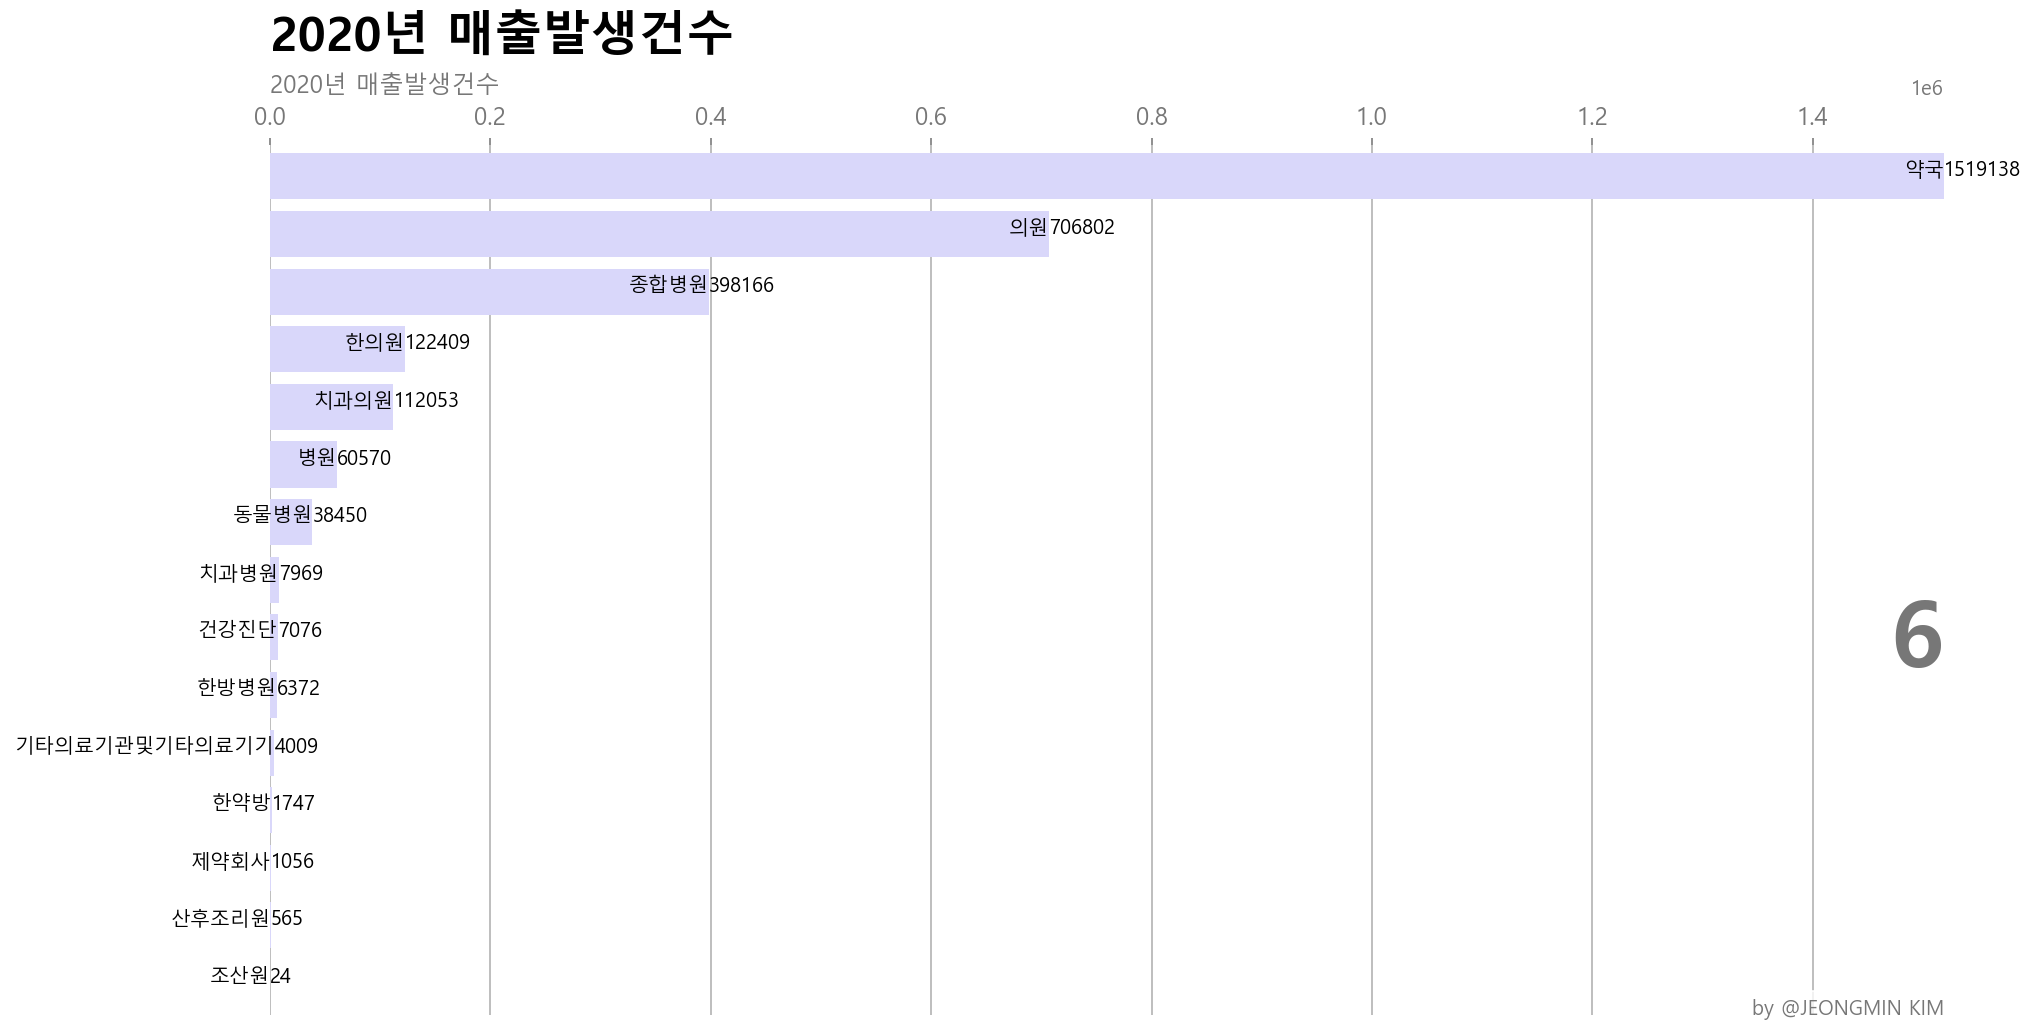

In [37]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 7))
HTML(animator.to_jshtml())

[Text(0.5, 1.0, '월별 카드 사용내역 데이터 (의료용품)')]

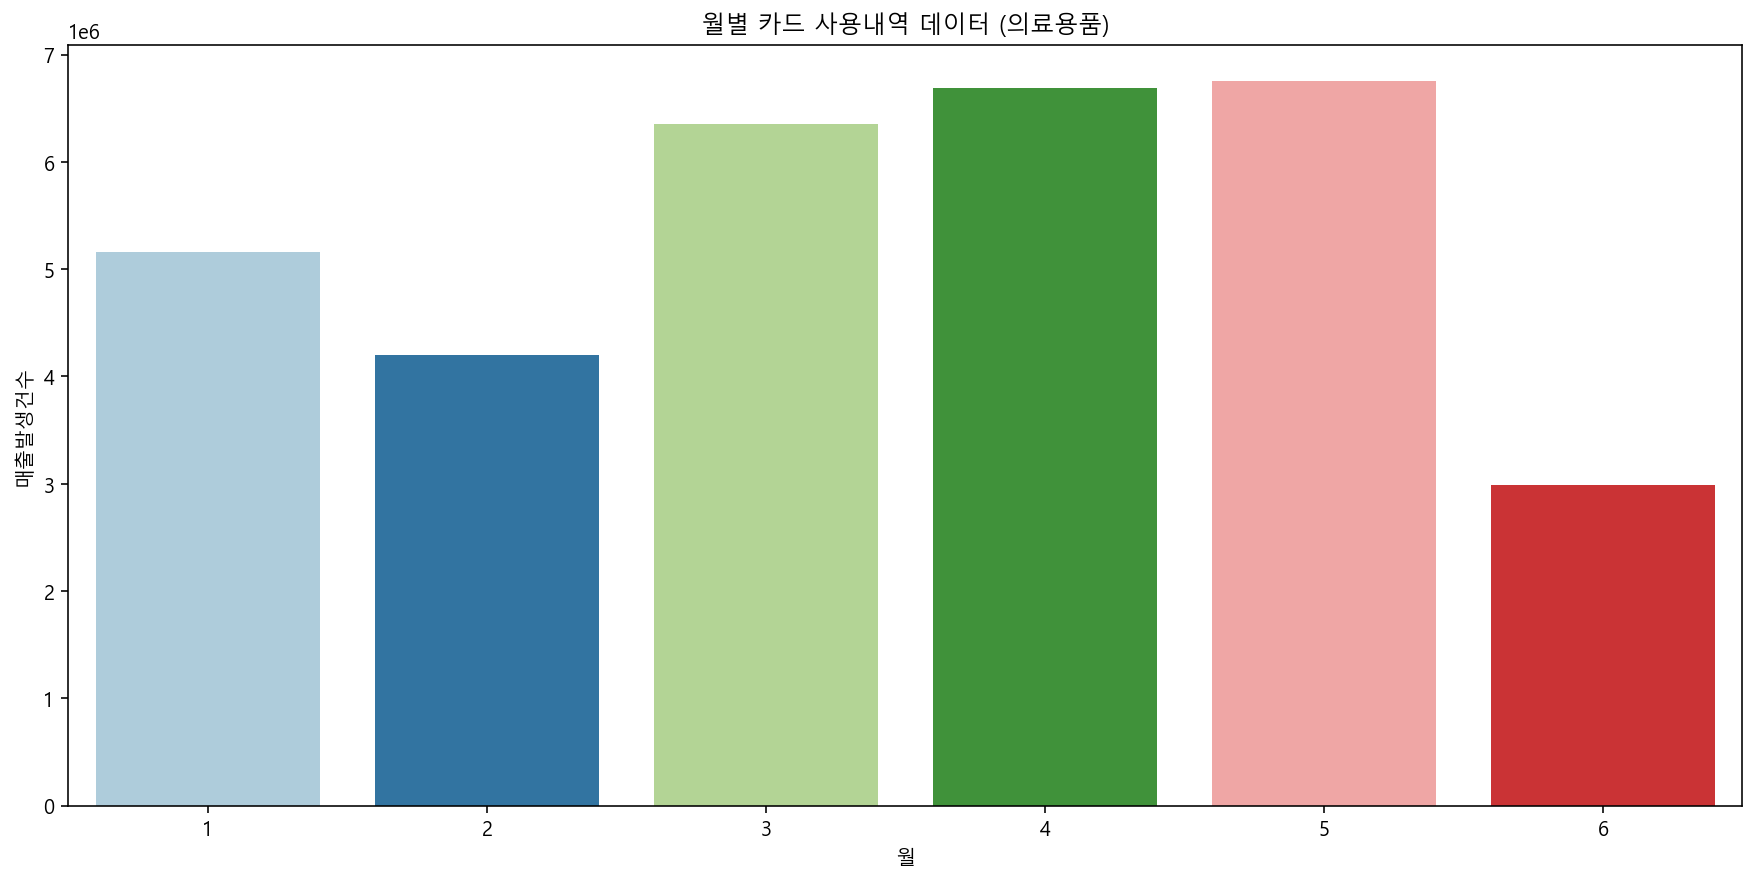

In [38]:
plt.figure(figsize = (15,7))
sns.barplot(data = health_month, x = "월", y = '매출발생건수', palette = "Paired").set(title = "월별 카드 사용내역 데이터 (의료용품)")

### 업종별 카드 사용내역 데이터(식품)

In [39]:
df = card_food.groupby(['업종명','월'])['매출발생건수'].sum().to_frame().reset_index().copy()

df = df.astype({'월' : object})

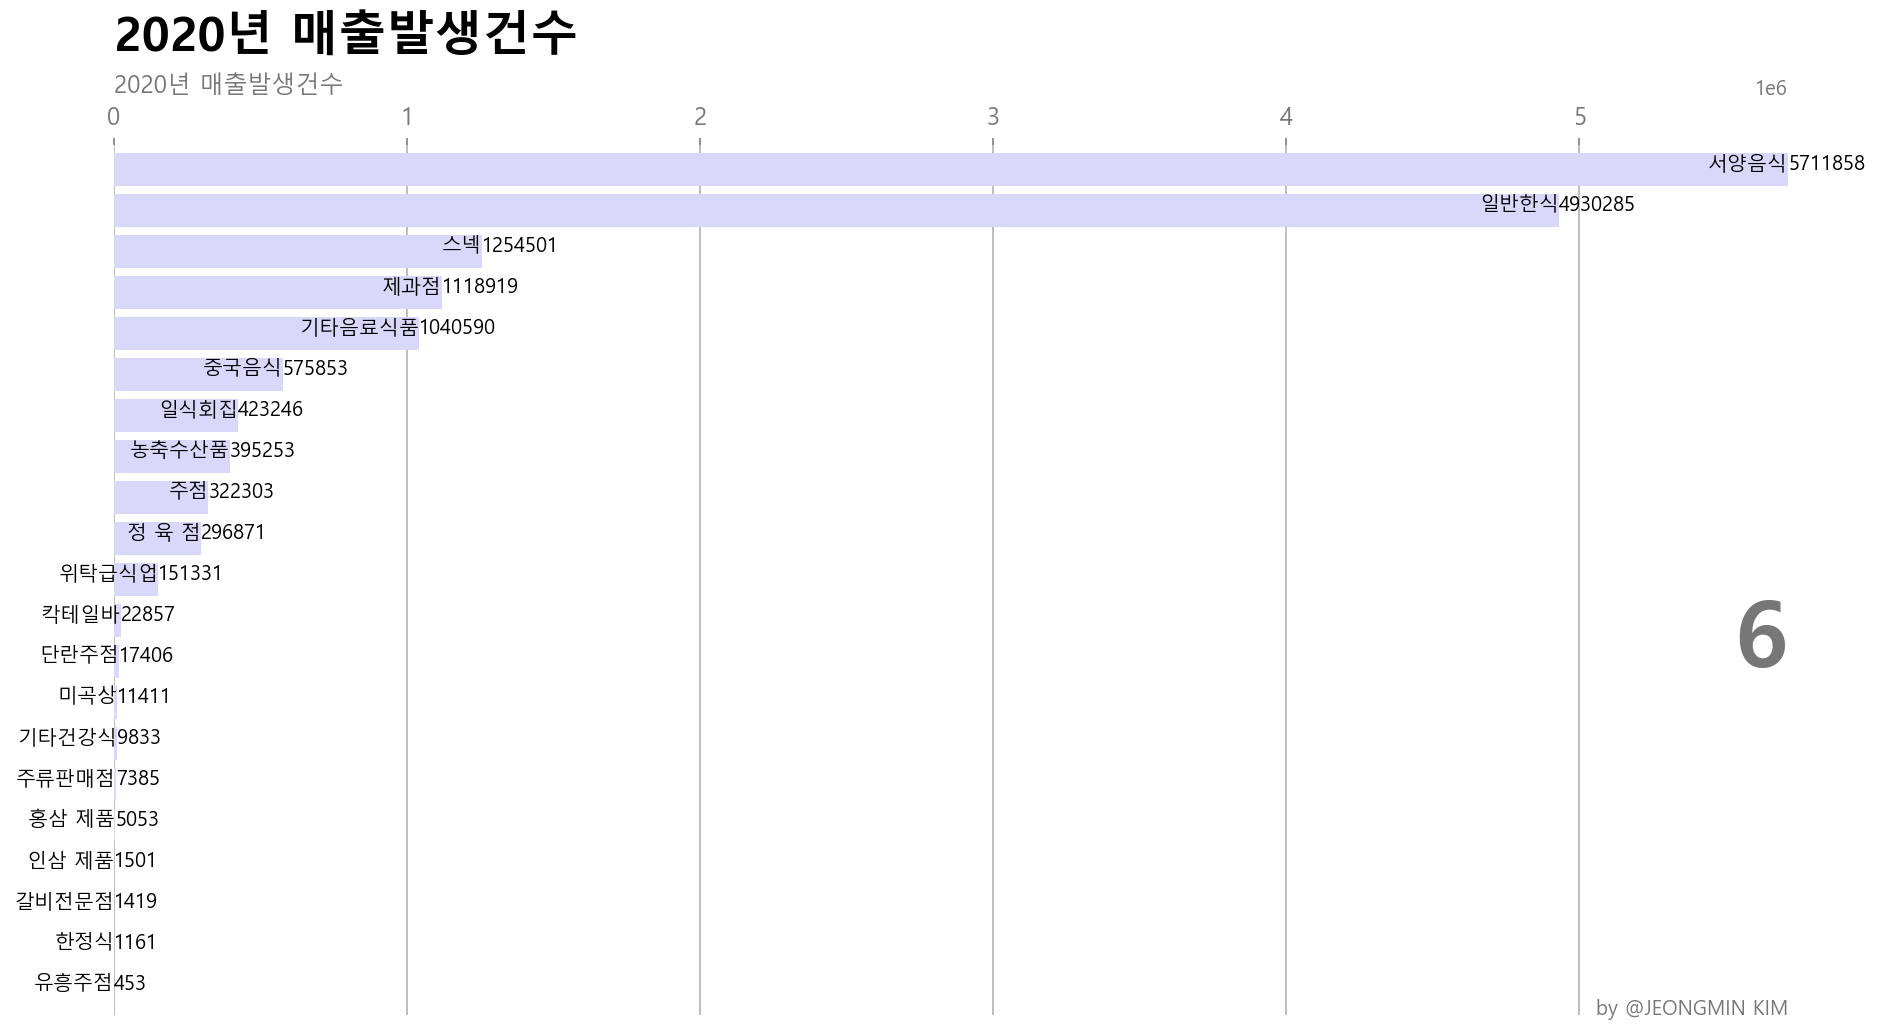

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 7))
HTML(animator.to_jshtml())

[Text(0.5, 1.0, '월별 카드 사용내역 데이터 (식품)')]

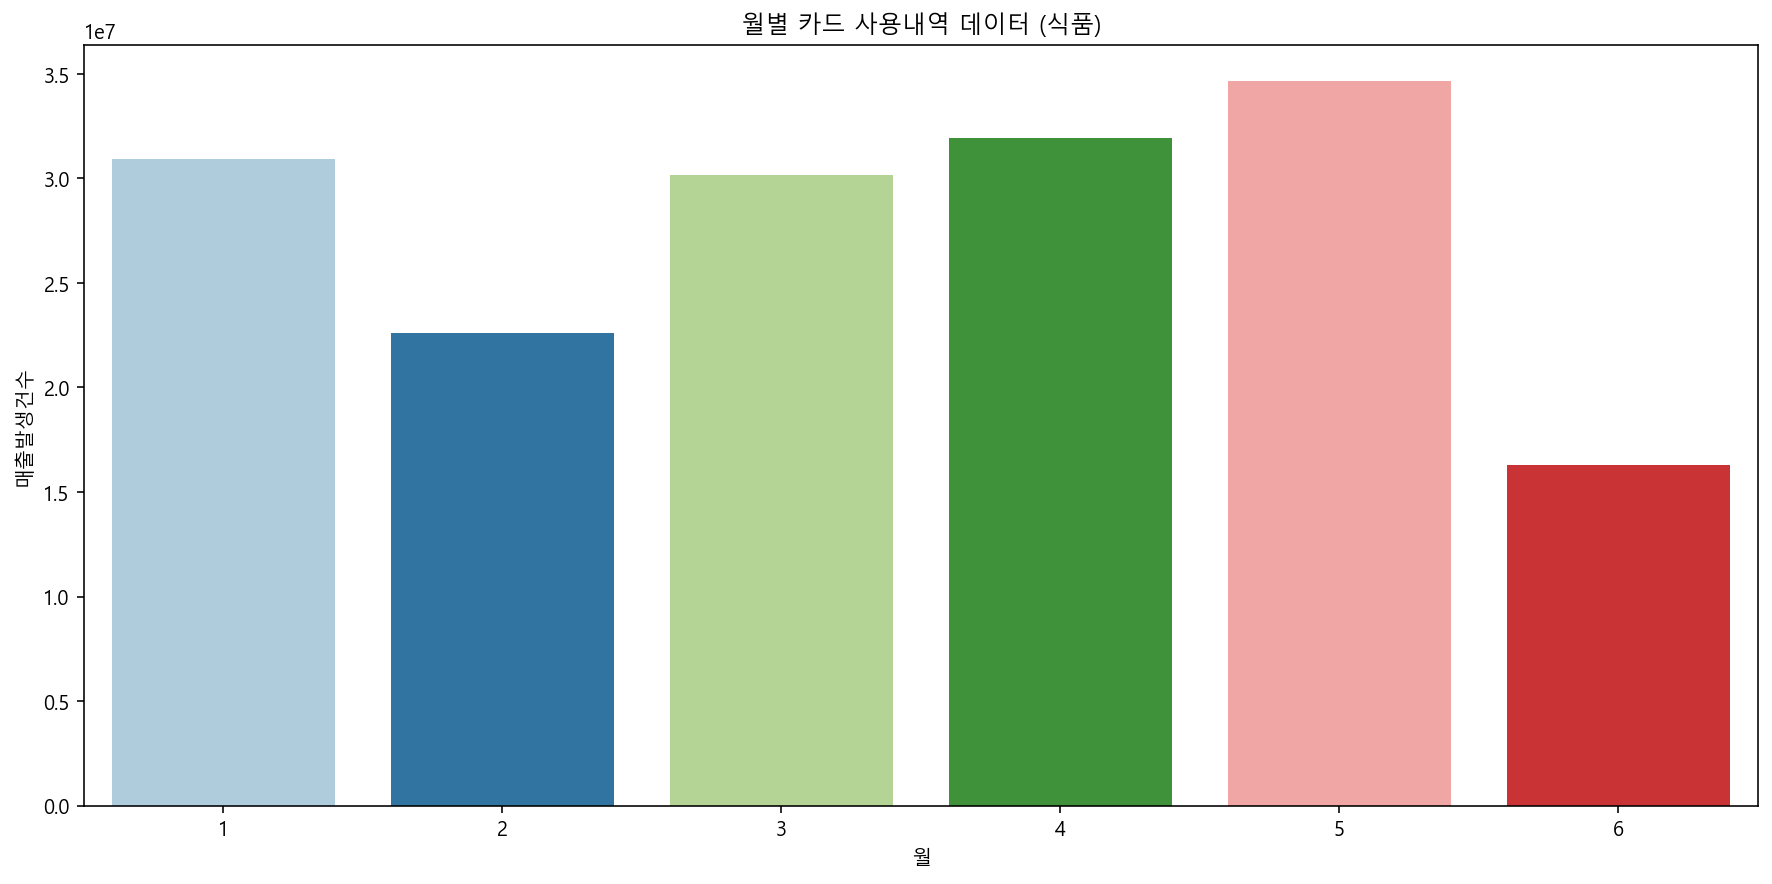

In [41]:
plt.figure(figsize = (15,7))
sns.barplot(data = food_month, x = "월", y = '매출발생건수', palette = "Paired").set(title = "월별 카드 사용내역 데이터 (식품)")

###  업종별 카드 사용내역 데이터(여행)
- 여행: 여행 업종에서는 택시에 대한 소비가 압도적으로 높았으며, 이는 코로나 발병으로 인해 대중교통을 기피하는 시민들의 현상을 반영하는 결과입니다. 

In [42]:
df = card_travel.groupby(['업종명','월'])['매출발생건수'].sum().to_frame().reset_index().copy()

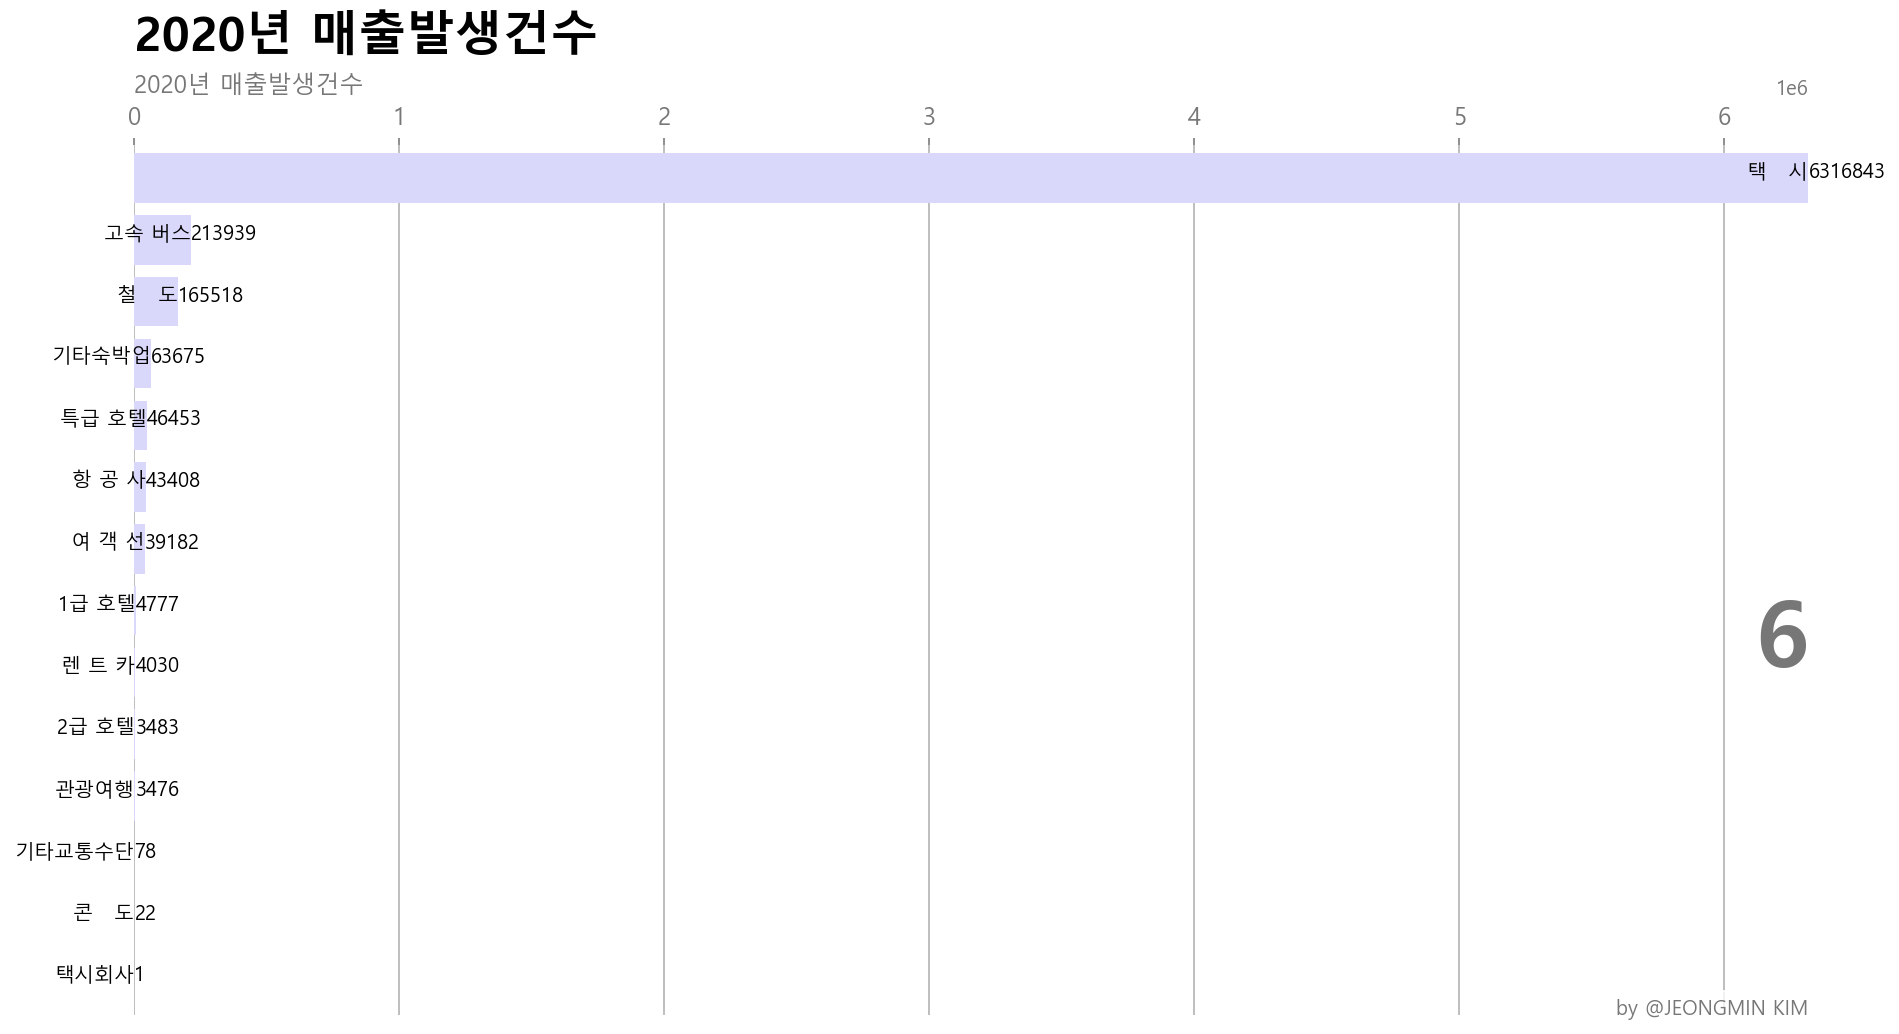

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1, 7))
HTML(animator.to_jshtml())

[Text(0.5, 1.0, '월별 카드 사용내역 데이터 (여행)')]

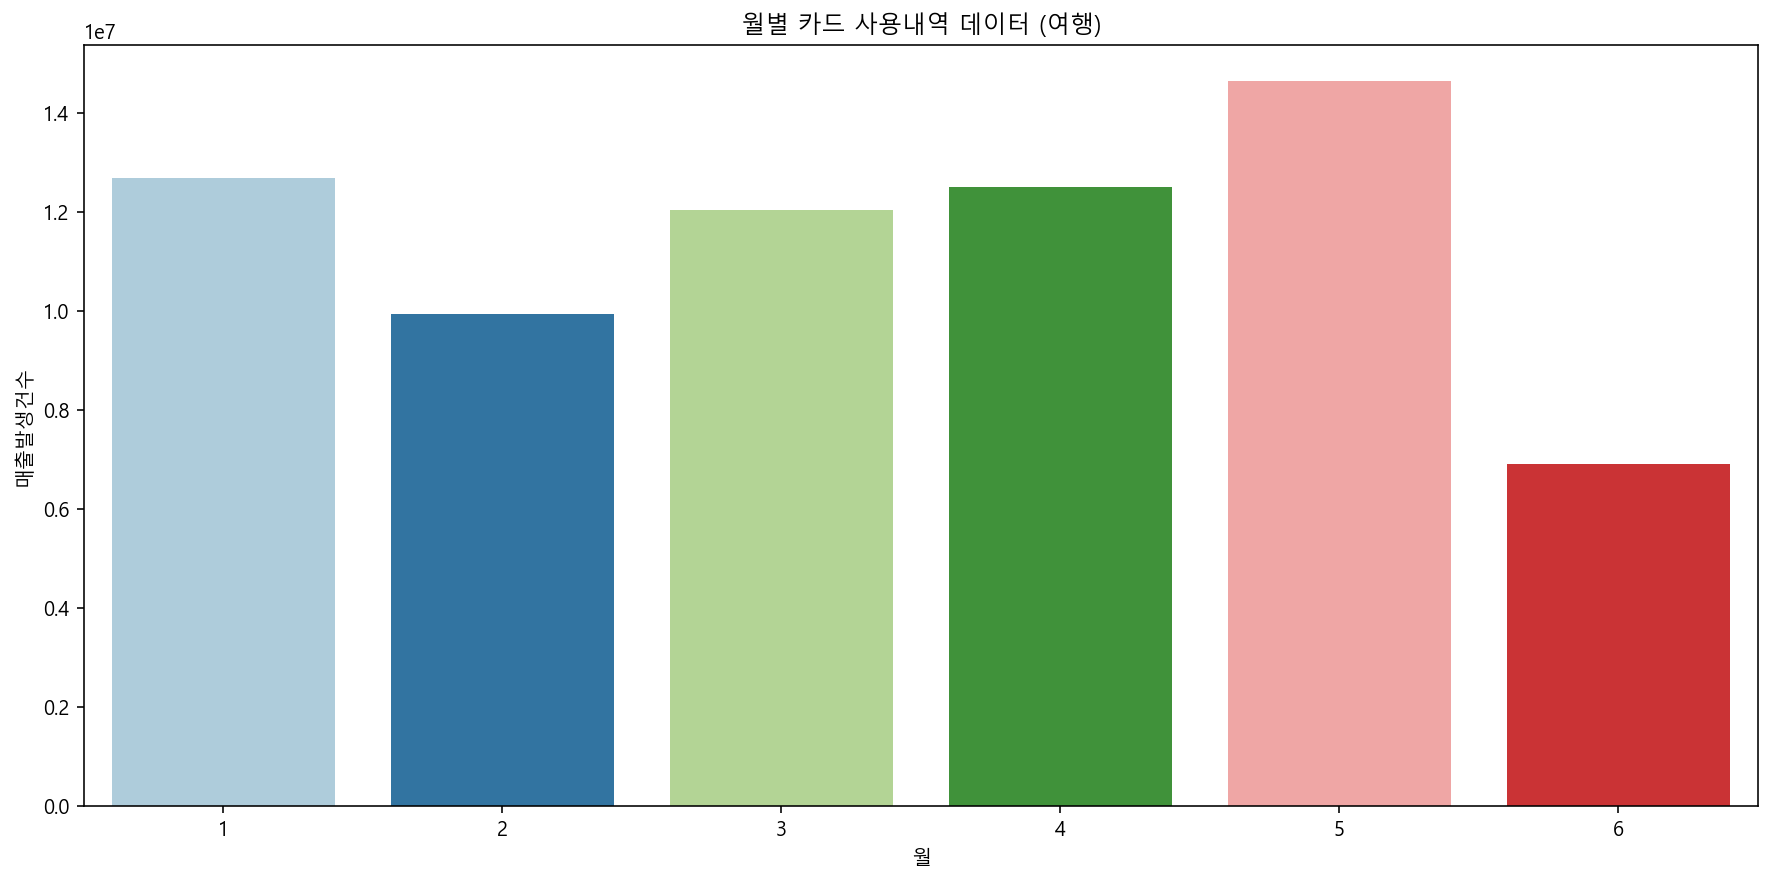

In [44]:
plt.figure(figsize = (15,7))
sns.barplot(data = travel_month, x = "월", y = '매출발생건수', palette = "Paired").set(title = "월별 카드 사용내역 데이터 (여행)")

### 매 월별로 식품과 의료용품, 여행 매출발생건수 비교
- 식품, 의료용품, 여행 업종에 대한 카드매출발생건수를 비교해본 결과 전체적으로 코로나가 시작된 1월에 소비가 대폭 감소하는 모습을 볼 수 있고, 4월까지 점점 증가하다 5월에 갑작스런 소비 감소의 모습을 볼 수 있습니다. 이는 5월 초반 이태원발 집단감염으로 인해 강화된 사회적 거리두기를 원인으로 연관지을 수 있습니다. 

In [45]:
#식품과 의료용품을 비교해보기 위해 식품과 의료용품 데이터를 Merge시켜준다.
card_health_food = pd.merge(food_month, health_month, on=['월'])
card_health_food_travel = pd.merge(card_health_food, travel_month, on =['월'])

In [46]:
xcol = '월'
cols='rgb(0,0,255)'
food=go.Bar(
    x=card_health_food_travel[xcol],
    y=card_health_food_travel["매출발생건수_x"],
    opacity=0.1,
    name="식품 매출발생건수",
    marker={'color':'MediumPurple', 'line':{'color':'White','width':1.4}},
    yaxis='y2'
)
health = go.Bar(
    x=card_health_food_travel[xcol],
    y=card_health_food_travel["매출발생건수_y"],
    name="건강(의료용품) 매출발생건수",
    opacity=0.5,
    marker={'color': "#379392", 'line':{'color':"white", 'width':1.4}},
    yaxis='y2'
        
)
travel = go.Bar(
    x=card_health_food_travel[xcol],
    y=card_health_food_travel["매출발생건수"],
    name="여행(관광) 매출발생건수",
    opacity=0.5,
    marker={'color': "lightblue", 'line':{'color':"white", 'width':1.4}},
    yaxis='y2'
        
)

layout = go.Layout(
    title = '<b>월 별 서울 카드매출건수 변화</b>',
    hovermode='x unified',
    xaxis = {'title':'주차별'},
    yaxis = {'title':'단위 [ 매출발생건수(건)]'},
    yaxis2 = {'title':'카드 매출건수 변화', 'overlaying':'y', 'side':'right'},
    showlegend = True)

data = [food, health, travel]
fig = go.Figure(data=data, layout=layout)
#plot(fig,show_link= False, filename='confirmed-released-card.html')
fig.show()

### 3. 코로나 확진자수와 카드사용률의 관계
코로나와 전체적인 소비량의 연관성을 살펴보기 위해 코로나 확진자, 격리해제자와, 의료용품, 식품, 여행에 대한 매출발생건수를 탐색해보았습니다.

In [47]:
# 사용내역접수일자 오름차순으로 정리
card_health = card_health.sort_values(by = ['사용내역접수일자'])
card_health = card_health.reset_index()
card_food = card_food.sort_values(by = ['사용내역접수일자'])
card_food = card_food.reset_index()
card_travel = card_travel.sort_values(by = ['사용내역접수일자'])

# 코로나 확진자 수와의 주차를 일치시키기 위해 1/19 데이터 전까지 drop
card_health.drop(card_health.index[card_health['사용내역접수일자'] < 20200119], inplace = True)
card_food.drop(card_food.index[card_food['사용내역접수일자'] < 20200119], inplace = True)
card_travel.drop(card_travel.index[card_travel['사용내역접수일자'] < 20200119], inplace=True)

# 기준일 20200119를 0주차라고 하였을 때 각 해당날짜의 주차를 계산하는 함수를 생성
def weekindexing(date):
    dt_mm = 1
    dt_dd = 19
    temp_m = date % 10000 // 100
    temp_d = date % 10000 % 100
    week = ((temp_m - dt_mm) * 30 - dt_dd + temp_d) // 7 + 1
    if week < 0:
        week = week * (-1)
    return week

card_travel['주차'] = card_travel['사용내역접수일자'].apply(weekindexing)
card_health['주차'] = card_health['사용내역접수일자'].apply(weekindexing)
card_food['주차'] = card_food['사용내역접수일자'].apply(weekindexing)

# 각 주차별로 매출발생건수를 groupby 해주었다.
card_health = card_health.groupby(["주차"])["매출발생건수"].sum()
card_food = card_food.groupby(["주차"])["매출발생건수"].sum()
card_travel = card_travel.groupby(["주차"])["매출발생건수"].sum()


card_health = card_health.to_frame()
card_health = card_health.reset_index()

card_food = card_food.to_frame()
card_food = card_food.reset_index()

card_travel = card_travel.to_frame()
card_travel = card_travel.reset_index()


### 4. 주차별 코로나 확진자 수와 카드 데이터 사용 내역의 연관성 비교

In [48]:
# 코로나 확진자 수 데이터
time = pd.read_csv("COVID_19/Time.csv")

# COVID_19/ Time.csv는 일자별 누적확진자수이기때문에 전 데이터에서 7일씩 인덱싱해준다.
time = time.iloc[:162:7]

# 주차별로 인덱싱해주기 위해 date 칼럼내 '-'를 ''로 바꿔주는 함수를 생성한다.
def parse(date):
    date = date.replace('-', '')
    return date

time['date'] = time['date'].apply(parse)
time['date'] = time['date'].astype(int)
time['주차'] = time['date'].apply(weekindexing)

time_week = time

# 코로나 누적환자수(time.csv)와 식품, 일용품, 여행에 대한 카드 매출발생건수 merge 시켜주기
corona_card = time_week.merge(card_health, on = '주차')
corona_card = corona_card.merge(card_food, on = '주차')
corona_card = corona_card.merge(card_travel, on = '주차')

# 날짜 별로 시각화해주기 위해 다시 데이터타임형식으로 변환
corona_card['date'] = pd.to_datetime(corona_card['date'], format = '%Y%m%d')

corona_card.rename(columns={'매출발생건수_x': '의료용품_매출발생건수', '매출발생건수_y': '식품_매출발생건수','매출발생건수':'여행_매출발생건수'}, inplace=True)

# Index 재설정
corona_card = corona_card.reset_index()

corona_card

,index,date,time,test,negative,confirmed,released,deceased,주차,의료용품_매출발생건수,식품_매출발생건수,여행_매출발생건수
0,0,2020-01-20,16,1,0,1,0,0,1,1346845,8064717,3433592
1,1,2020-01-27,16,61,56,4,0,0,2,1556686,7590715,3952034
2,2,2020-02-03,16,490,414,15,0,0,3,520016,3109468,2112741
3,3,2020-02-10,16,3110,2552,27,4,0,4,629030,3668016,1059192
4,4,2020-02-17,16,8718,7980,30,10,0,5,1366262,7770873,3702697
5,5,2020-02-24,16,32756,20292,833,24,8,6,1185942,5833959,2593350
6,6,2020-03-02,0,109591,71580,4212,31,22,7,1306672,6523570,2475858
7,7,2020-03-09,0,196618,171778,7382,166,51,8,1436681,6809277,2657255
8,8,2020-03-16,0,274504,251297,8236,1137,75,9,1496991,6876524,2743734
9,9,2020-03-23,0,338036,315447,8961,3166,111,10,1559998,7183950,2768781


In [49]:
xcol = 'date'
cols='rgb(0,0,255)'
confirmed=go.Bar(
    x=corona_card[xcol],
    y=corona_card["confirmed"],
    opacity=0.1,
    name="코로나 확진자수",
    marker={'color':'MediumPurple', 'line':{'color':'White','width':1.4}},
    yaxis='y2'
)
released = go.Bar(
    x=corona_card[xcol],
    y=corona_card["released"],
    name="코로나 완치자수",
    opacity=0.5,
    marker={'color': "#379392", 'line':{'color':"white", 'width':1.4}},
    yaxis='y2'
        
)


card1=go.Scatter(
    x=corona_card[xcol],
    y=corona_card["의료용품_매출발생건수"],
    name="의료용품_매출발생건수",
    marker={'color':'#C89EC4', 'line':{'color':'Lavender', 'width':3}})

card2=go.Scatter(
    x=corona_card[xcol],
    y=corona_card["식품_매출발생건수"],
    name="식품_매출발생건수	",
    marker={'color':'#84B1ED', 'line':{'color':'Lavender', 'width':3}})

card3=go.Scatter(
    x=corona_card[xcol],
    y=corona_card["여행_매출발생건수"],
    name="여행카드거래발생건수",
    marker={'color':'#EE7785', 'line':{'color':'Lavender', 'width':3}})


layout = go.Layout(
    title = '<b>코로나 누적 확진자수 대비 서울의 평균 카드매출액수 변화</b>',
    hovermode='x unified',
    xaxis = {'title':'주차별'},
    yaxis = {'title':'단위 [ 매출발생건수(건)]'},
    yaxis2 = {'title':'코로나 누적 확진자수', 'overlaying':'y', 'side':'right'},
    showlegend = True,

)


data = [confirmed, released, card1, card2, card3]
fig = go.Figure(data=data, layout=layout)
#plot(fig,show_link= False, filename='confirmed-released-card.html')
fig.show()

재난지원금 등의 정부 정책으로 매출발생건수가 전반적인 상승세를 보이지만 집단감염 등의 코로나 현황에 큰 영향을 받은 것으로 보입니다.
코로나가 처음 발병한 2월 초반, 고강도 사회적 거리두기가 시행된 4월초, 이태원발 집단감염이 발생한 5월 중순에 매출발생건수는 갑작스런 하락세를 보입니다.
확진자가 점차적으로 줄어들고 격리해제자가 늘어남에 따라 매출발생건수는 점차적으로 상승할 것으로 예상됩니다. 

## 유동인구 지도

- 카드 매출발생건수, 유동인구현황, 소비자성장지수(cgi)를 지도에 나타내기위해 데이터 전처리를 해주었다.

In [50]:
# Card 데이터의 동 이름과 Master 데이터의 동 이름을 비교하기 위해 master 데이터와 merge
card_code = card.groupby(['행정동명'])["매출발생건수"].sum()
card_code = card_code.to_frame().reset_index()

# card_code, master 데이터를 '행정동명'으로 inner join하여 merge
map_data = pd.merge(card_code, master, how = 'inner', on='행정동명')

map_data = map_data.groupby(["시군구명"])["매출발생건수"].sum()

map_data = map_data.to_frame().reset_index()

master = master.astype({'행정동코드':int})

# fpopl.csv를 전처리하는 과정
fpopl = pd.read_csv("fpopl.csv")

# fpop => 유동인구수를 행정동코드별로 그룹화 시켜줌
fpop = fpopl.groupby(['adstrd_code'])['popltn_cascnt'].sum()

fpop = fpop.to_frame().reset_index()

fpop.columns = ['행정동코드','유동인구수']

# fpop, master 데이터를 '행정동코드'로 inner join 시켜줌
fpopl_data = pd.merge(fpop, master, how = 'inner', on='행정동코드')

fpop_data = fpopl_data.groupby(["시군구명"])["유동인구수"].sum()
fpop_data = fpop_data.to_frame().reset_index()

# 이렇게 만들어준 fpop_data, map_data를 merge 시켜줌
fpopl_card_data = pd.merge(fpop_data, map_data, on = "시군구명")

# index.csv 파일의 영어 칼럼명을 한글 칼럼명으로 바꿔준 후
index = pd.read_csv("index.csv")
index.columns = ['기준일', '대분류', '중분류', '나이', '성별', '시도명', '시군구명', '성장지수']

# 시군구명별로 성장지수의 평균을 그룹화해줌
index = index.groupby(['시군구명'])['성장지수'].mean()

index = index.to_frame().reset_index()

# 시군구명로 merge함

fpopl_card_data = pd.merge(fpopl_card_data, index, on = "시군구명")

In [51]:
# 지도 사용에 필요한 라이브러리 불러오기
import json
import folium
geo_path = 'seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding= 'utf-8'))

In [52]:
geo_path = 'seoul_municipalities_geo_simple.json'

import json
geo_json = json.load(open(geo_path, encoding="utf-8"))
geo_json["features"][0]['properties']["name"]

'강동구'

In [53]:
m = folium.Map([37.5502, 126.982])

folium.Choropleth(
    geo_data=geo_json,
    name='서울시 구별 카드매출건수',
    data=fpopl_card_data,
    columns=['시군구명', '매출발생건수'],
    key_on='feature.properties.name',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='서울시 구별 카드매출건수'
).add_to(m)

folium.Choropleth(
    geo_data=geo_json,
    name='서울시 구별 유동인구수',
    data=fpopl_card_data,
    columns=['시군구명', '유동인구수'],
    key_on='feature.properties.name',
    fill_color='PuBu',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='서울시 구별 유동인구수'
).add_to(m)

folium.Choropleth(
    geo_data=geo_json,
    name='서울시 구별 성장지수',
    data=fpopl_card_data,
    columns=['시군구명', '성장지수'],
    key_on='feature.properties.name',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='서울시 구별 성장지수'
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m

# 결론

![CGI](image/1.png)

![DATA1](image/DATA1.png)

![DATA2](image/DATA2.png)

![last](image/last.png)